In [1]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import keras.backend.tensorflow_backend as ktf

import matplotlib.pyplot as plt

from common import *

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

Using TensorFlow backend.


numpy ver.: 1.13.1
pandas ver.: 0.19.0
tensorflow ver.: 1.0.0
keras ver.: 2.0.8


In [2]:
def get_session(gpu_fraction=1):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

## Functions

### Functions for generate data

In [3]:
def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.21, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [4]:
def info(msg):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " " + msg)

## Load data

In [5]:
data = prep_data('../data/4A_1_201705_201710.csv')
print(len(data))

1213677


Subset the part of the 4A line that are identical across all journey patterns.

In [6]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 32)]
data = data[data['LinkTravelTime'].notnull()]
assert len(data['LinkRef'].unique()) == 32
n = len(data)
print(n)

907390


In [7]:
lags = 4 * 8
preds = 3

## Train and test

In [8]:
# Devide into test and train
data_train = data[data['DateTime'] < '2017-10-10']
data_test = data['2017-10-10' <= data['DateTime']]
n_train = len(data_train)
n_test = len(data_test)
info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 100. * n_train / n))
info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 100. * n_test / n))

2017-11-02 14:29:09 - Train size :   873720 (96.29%) 
2017-11-02 14:29:09 - Test size  :    33670 (3.71%) 


In [9]:
# Mean center and scale
(means, scales, low, upr) = fit_scale(data_train)
assert means.shape == (4 * 24 * 7, 32)
assert len(scales) == 32
assert low.shape == (4 * 24 * 7, 32)
assert upr.shape == (4 * 24 * 7, 32)

In [10]:
data_train_no = data_train
data_test_no = data_test

In [11]:
ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train_no, means, scales)
ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test_no, means, scales)

# Create rolling window tensor
X_train, Y_train, Y_ix_train, Y_rm_mean_train, Y_scale_train, Y_w_train = roll(ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lags, preds)
X_test, Y_test, Y_ix_test, Y_rm_mean_test, Y_scale_test, Y_w_test = roll(ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lags, preds)

X_train = X_train[:,:,:,np.newaxis,np.newaxis]
Y_train = Y_train[:,:,:,np.newaxis,np.newaxis]
X_test = X_test[:,:,:,np.newaxis,np.newaxis]
Y_test = Y_test[:,:,:,np.newaxis,np.newaxis]

info('- X_train shape : {:>20}    X_test shape : {:>20}'.format(X_train.shape, X_test.shape))
info('- Y_train shape : {:>20}    Y_test shape : {:>20}'.format(Y_train.shape, Y_test.shape))

2017-11-02 14:29:13 - X_train shape : (15512, 32, 32, 1, 1)    X_test shape :  (544, 32, 32, 1, 1)
2017-11-02 14:29:13 - Y_train shape : (15512, 3, 32, 1, 1)    Y_test shape :   (544, 3, 32, 1, 1)


In [12]:
global_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

model = build_model(lags, preds, len(lns_train))

# Train
history = model.fit(X_train, Y_train,
                    batch_size = 64, epochs = 30,
                    shuffle = False, validation_data = (X_test, Y_test),
                    verbose = 2, callbacks = [early_stopping])
model.save('models/ConvLSTM_3x15min_10x64-5x64-10x64-5x64_Comparison.h5') 

Y_true = Y_test.squeeze() * Y_scale_test + Y_rm_mean_test
Y_naive = Y_rm_mean_test
Y_pred = model.predict(X_test).squeeze() * Y_scale_test + Y_rm_mean_test

Y_true_total = np.sum(Y_true * Y_w_test, axis = 2).squeeze()
Y_naive_total = np.sum(Y_naive * Y_w_test, axis = 2).squeeze()
Y_pred_total = np.sum(Y_pred * Y_w_test, axis = 2).squeeze()
    
for t in range(preds):
    mask = Y_true_total[:,t] > 0
    Y_true_total_t = Y_true_total[mask, t] / 60
    Y_naive_total_t = Y_naive_total[mask, t] / 60
    Y_pred_total_t = Y_pred_total[mask, t] / 60  

    error_naive_total_t = (Y_naive_total_t - Y_true_total_t)
    error_lstm_total_t = (Y_pred_total_t - Y_true_total_t)

    mae_ha = np.mean(np.abs(error_naive_total_t))
    rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
    mape_ha = np.mean(np.abs(error_naive_total_t) / Y_true_total_t) * 100

    mae_lstm = np.mean(np.abs(error_lstm_total_t))
    rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
    mape_lstm = np.mean(np.abs(error_lstm_total_t) / Y_true_total_t) * 100

    info("- t + %d - HA       - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))
    info("- t + %d - ConvLSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
    info("- t + %d - *        - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))


Train on 15512 samples, validate on 544 samples
Epoch 1/30
111s - loss: 2.1111 - val_loss: 2.6158
Epoch 2/30
109s - loss: 2.0629 - val_loss: 2.0832
Epoch 3/30
109s - loss: 2.0329 - val_loss: 2.0241
Epoch 4/30
109s - loss: 2.0075 - val_loss: 2.0039
Epoch 5/30
109s - loss: 1.9746 - val_loss: 1.9236
Epoch 6/30
99s - loss: 1.9518 - val_loss: 1.8660
Epoch 7/30
109s - loss: 1.9265 - val_loss: 1.9618
Epoch 8/30
109s - loss: 1.8888 - val_loss: 2.2275
Epoch 9/30
109s - loss: 1.8743 - val_loss: 1.9905
Epoch 10/30
109s - loss: 1.8442 - val_loss: 1.9166
2017-11-02 14:47:27 - t + 1 - HA       - MAE:  5.68 - RMSE:  9.28 - MAPE:  6.27
2017-11-02 14:47:27 - t + 1 - ConvLSTM - MAE:  4.08 - RMSE:  6.10 - MAPE:  5.26
2017-11-02 14:47:27 - t + 1 - *        - MAE: -1.60 - RMSE: -3.18 - MAPE: -1.01
2017-11-02 14:47:27 - t + 2 - HA       - MAE:  5.64 - RMSE:  9.22 - MAPE:  6.24
2017-11-02 14:47:27 - t + 2 - ConvLSTM - MAE:  4.32 - RMSE:  6.61 - MAPE:  5.47
2017-11-02 14:47:27 - t + 2 - *        - MAE: -1.32 

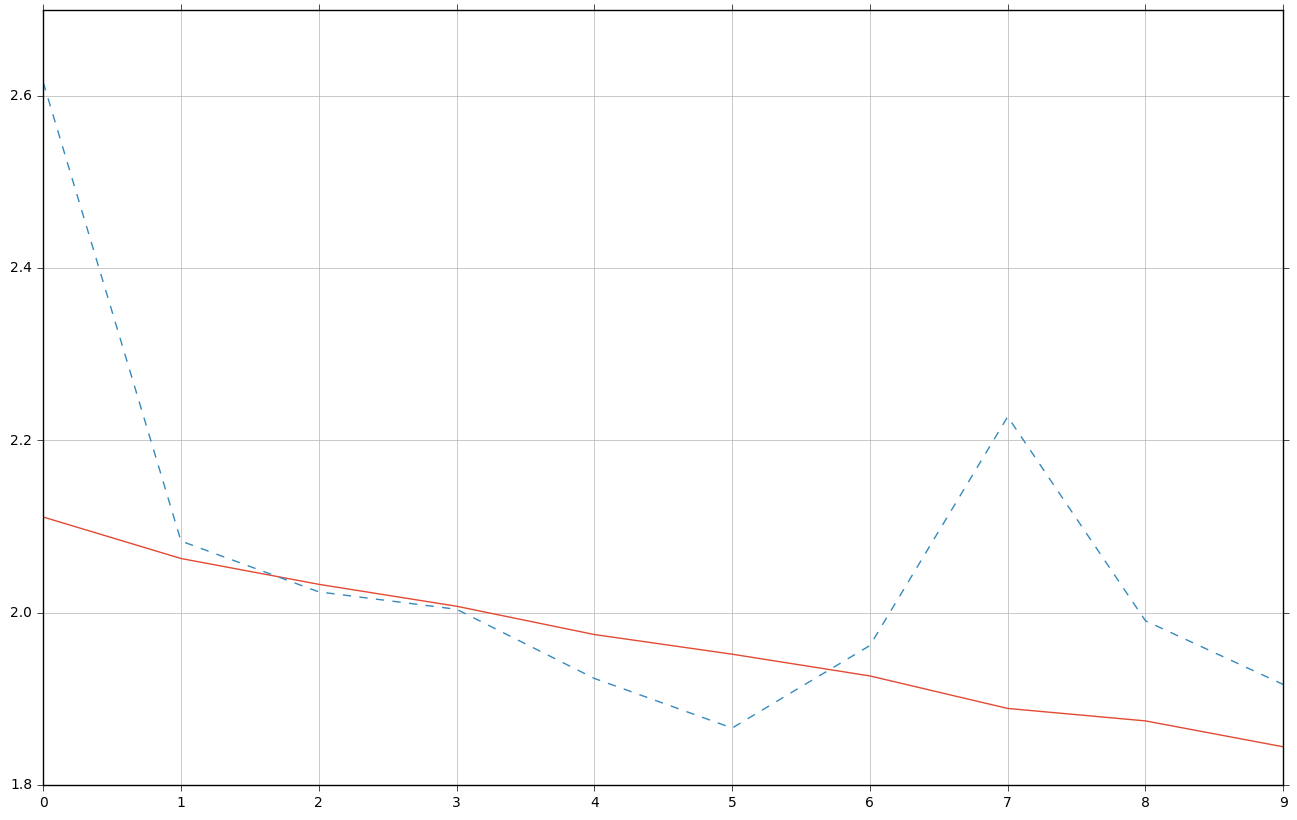

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle = '--')

In [19]:
output = pd.DataFrame(data = Y_pred[:,0,:], index = Y_ix_test, columns = lns_test)

In [20]:
output.to_csv('../data/Output-ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison_2.csv')